# 과제
### 2022235027 민현기


- 답변의 제출은 반드시 "학번.pdf"로 제출하고, 추가적으로 분석에 활용된 python code를 원본형식으로 제출하라.
    - (코드 파일에 # 이나 Jupyternote book 기능을 이용해 설명만 추가하는 형식의 제출은 정식 과제 점수로 인정하지 않음.)

In [1]:
# import requests
# from urllib import parse
# import googlemaps
# import pandas as pd
# import numpy as np

# def matzip_api(coordinate):
#     address = 'https://www.daegufood.go.kr/kor/api/tasty.html?mode=json&addr='
#     coordinate = parse.quote(coordinate)
#     response = requests.get(address+coordinate)
    
#     return response.json(strict=False)

# location = ['중구', '동구', '서구', '남구', '북구', '수성구', '달서구', '달성군']

# gmaps = googlemaps.Client(key='')

# def make_df(location):
#     daegu_matzip = {i:matzip_api(i) for i in location}
#     df = []
#     for i in location:
#         local_df = pd.DataFrame(daegu_matzip[i]['data'])
#         local_df['LOCATION'] = i
#         df.append(local_df)
        
#     return pd.concat(df).reset_index(drop=True)

# df = make_df(location)

# df['coordinate'] = df['GNG_CS'].apply(lambda x: list(gmaps.geocode(x)[0]['geometry']['location'].values()))
# df['lat'] = df['coordinate'].apply(lambda x: x[0])
# df['lon'] = df['coordinate'].apply(lambda x: x[1])

# df.to_csv('matzip.csv', encoding='utf-8-sig', index=False)

### 1. 좌표로 변환된 대구맛집들에 대해 K=10인 경우 각 행정구(중구, 남구, 달성군 등등) 별로 10개 k-mean cluster의 비율은 어떠한가?

 - 클러스터 x 행정구 형태의 표를 만들고 클러스터의 숫자를 채운뒤 해당 표의 각 행과 열의 합계 항목을 통해 답변하라.
 - 초기값을 다르게 설정한 경우에 결과는 어떻게 달라지는가? 
 - 단, sklearn 등 계산 library 사용은 금지한다. (numpy, panda 등은 이용 가능하다.)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('matzip.csv')

In [4]:
df.drop_duplicates(subset=['lat', 'lon'], inplace=True)

In [5]:
def initialize_clusters(coord, k):
    centroids = coord.copy()
    np.random.shuffle(centroids)
    return centroids[:k]
    
def get_distances(centroid, coord):
    return np.linalg.norm(coord - centroid, axis=1)

In [6]:
coord = np.array(list(zip(df['lat'], df['lon'])))

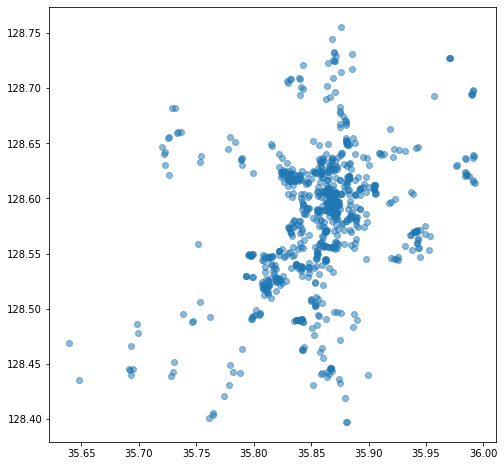

In [7]:
plt.figure(figsize=(8, 8))
plt.scatter(coord[:, 0], coord[:, 1], alpha=0.5)
plt.show()

In [8]:
k = 10
maxiter = 100
centroids = initialize_clusters(coord, k)

classes = np.zeros(coord.shape[0], dtype=np.float64) # 클러스터 할당 벡터
distances = np.zeros([coord.shape[0], k], dtype=np.float64) # distance matrix

for i in range(maxiter):
    # 수렴을 위한 centroids 이동 단계
    for i, c in enumerate(centroids):
        distances[:, i] = get_distances(c, coord)
        
    classes = np.argmin(distances, axis=1)
    
    # centrodis 클래스별 중심점으로 이동
    for c in range(k):
        centroids[c] = np.mean(coord[classes == c], 0)

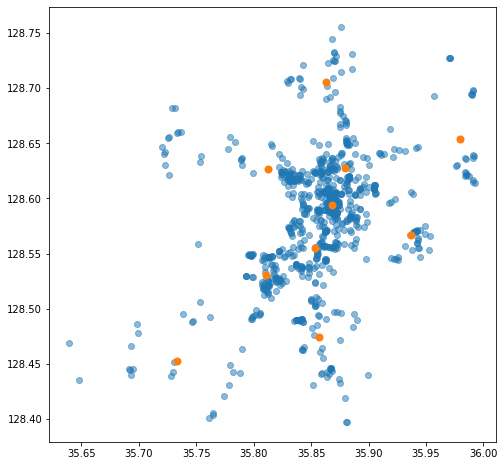

In [9]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(coord[:,0], coord[:,1], alpha=0.5)
ax.scatter(centroids[:,0], centroids[:,1], marker='o', lw=2)
plt.show()

In [10]:
def custom_kmeans_clustering(df, k, location, maxiter=100):
    df_result = []
    
    for name in location:
        local_df = df[df['LOCATION'] == name]
        coord = np.array(list(zip(local_df['lat'], local_df['lon'])))
        
        centroids = initialize_clusters(coord, k)

        classes = np.zeros(coord.shape[0], dtype=np.float64) # 클러스터 할당 벡터
        distances = np.zeros([coord.shape[0], k], dtype=np.float64) # distance matrix

        for i in range(maxiter):
            for i, c in enumerate(centroids):
                distances[:, i] = get_distances(c, coord)

            classes = np.argmin(distances, axis=1)

            # centrodis 클래스별 중심점으로 이동
            for c in range(k):
                centroids[c] = np.mean(coord[classes == c], 0)
                
        df_result.append(pd.DataFrame(pd.DataFrame(classes, columns=['cluster']).value_counts(), columns=[name]))
        
    return pd.concat(df_result, axis=1)

In [11]:
location = ['중구', '동구', '서구', '남구', '북구', '수성구', '달서구', '달성군']

In [12]:
custom_kmeans_clustering(df, k=10, location=location)

,중구,동구,서구,남구,북구,수성구,달서구,달성군
cluster,,,,,,,,
6,31,17,2,7,11,6,22,14
5,28,9,4,8,9,9,1,21
1,24,16,3,11,15,12,16,6
0,23,31,6,2,7,17,13,3
9,22,11,5,7,15,16,26,7
3,13,10,13,2,2,4,5,15
4,13,7,6,4,6,25,12,7
7,12,5,7,5,1,10,26,5
2,8,12,4,4,2,20,20,9


### 2. 클러스터 계산 방식을 Hierarchical clustering 방식으로 변경할 경우, 대구 맛집을 가장 잘 표현하는 클러스터는 몇개인가?(어떤 방식을 통해서 결론을 도출하였는지를 포함하여 논리적 근거를 명확히 밝혀라)

 - 단, sklearn 등 계산 library 사용은 금지한다. (numpy, panda 등은 이용 가능하다.)

In [13]:
from tqdm import tqdm

In [37]:
distance_matrix = np.zeros((coord.shape[0], coord.shape[0])) 
coord_dict = {idx: value for idx, value in enumerate(coord)} # 좌표 정보 저장
cluster_list = [i for i in range(coord.shape[0])] # cluster 정보 저장

first_step = [] # 좌표값 중복..?
for i in tqdm(range(len(coord_dict))):
    for j in range(len(coord_dict)):
        if np.linalg.norm(coord_dict[i] - coord_dict[j]) == 0:
            if i != j:
                first_step.append([i, j])
        distance_matrix[i, j] = np.linalg.norm(coord_dict[i] - coord_dict[j])
        
for i, j in first_step:
    if j in cluster_list:
        if cluster_list[j] != cluster_list[i]:
            cluster_list[j] = i
            

            
cluster_list = [cluster_list]

distance_matrix = np.triu(distance_matrix, k=1)
distance_matrix = np.where(distance_matrix==0, np.inf, distance_matrix)

100%|████████████████████████████████████████████████████████████████████████████████| 895/895 [00:09<00:00, 98.66it/s]


In [38]:
# for i in tqdm(range(len(np.unique(cluster_list)))):
for i in tqdm(range(563)):
    next_step = cluster_list[-1].copy()
    
    min_i = np.where(distance_matrix == np.min(distance_matrix))[0][0]
    min_j = np.where(distance_matrix == np.min(distance_matrix))[1][0]
    
    # print(f'---변경 전 i 클러스터: {next_step[min_i]}, j 클러스터: {next_step[min_j]}')
    # next_step[min_j] = min_i # index 값 하나만 변경 X, 클러스터 값 전체 수정 필요
    next_step = [next_step[min_i] if idx == min_j else value for idx, value in enumerate(next_step)]
    
    cluster_list.append(next_step)
    
    # 클러스터 평균 중심점으로 좌표 이동
    coord_dict[min_i] = np.mean(np.array([coord_dict[min_i], coord_dict[min_j]]), axis=0)
    
    distance_matrix[:, min_j] = np.inf
    distance_matrix[min_j, :] = np.inf
    
    for i in range(len(coord_dict)):
        distance_matrix[:, min_i] = np.linalg.norm(coord_dict[i] - coord_dict[min_i])
        
    # print(f'i: {min_i}, j: {min_j}')
    # print(f'---변경 후 i 클러스터: {next_step[min_i]}, j 클러스터: {next_step[min_j]}')
    # print(f'클러스터 갯수: {len(np.unique(next_step))}')
    # print('')

100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:07<00:00, 72.82it/s]


In [39]:
len(np.unique(next_step))

334

In [40]:
min_i

838

In [41]:
min_j

844

In [42]:
distance_matrix[809, 810]

0.02783260179034021

In [43]:
next_step[809]

809

In [44]:
next_step[810]

810